# 0. Import Library

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)
from matplotlib import transforms
import matplotlib.animation as animation
import time as time

sns.set_theme()

# 2. Data Understanding
# 2.1. Tổng quan kích thước, kiểu dữ liệu

In [35]:
df = pd.read_csv('data/kill_match_stats_v2.csv')
df.head()

,killed_by,type,time,phase,dis,kx,ky,vx,vy
0,Falling,Self,719,1,0,381840.7,424408.4,381840.7,424408.4
1,M416,AR,158,1,269,451052.9,629640.1,450792.1,629575.1
2,BlueZone,Zone,1646,5,0,468805.0,430984.8,468805.0,430984.8
3,BlueZone,Zone,1788,7,0,498605.2,442824.2,498605.2,442824.2
4,Mini 14,DMR,89,1,142,446881.4,629891.8,446780.2,629792.2


In [36]:
df.shape

(1518464, 9)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1518464 entries, 0 to 1518463
Data columns (total 9 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   killed_by  1518464 non-null  object 
 1   type       1518464 non-null  object 
 2   time       1518464 non-null  int64  
 3   phase      1518464 non-null  int64  
 4   dis        1518464 non-null  int64  
 5   kx         1518464 non-null  float64
 6   ky         1518464 non-null  float64
 7   vx         1518464 non-null  float64
 8   vy         1518464 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 104.3+ MB


## 2.2. Phân bố của dữ liệu trong từng cột
### 2.2.1. Các cột tọa độ

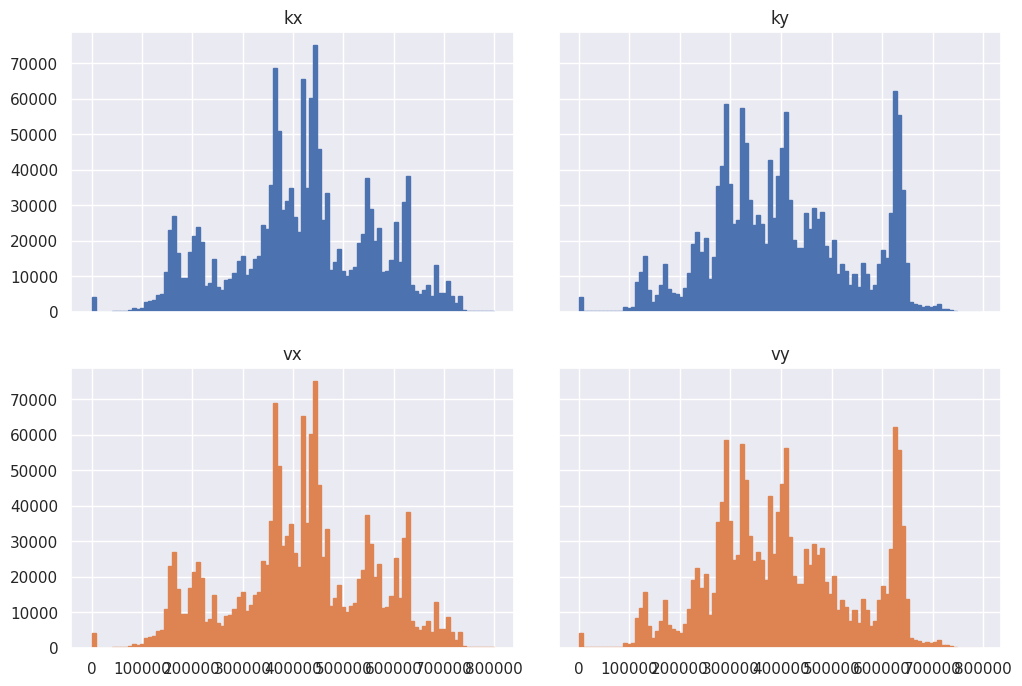

In [38]:
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(12, 8), sharex = 'col', sharey = 'row')
fig.subplots_adjust(wspace = 0.1)

axes[0][0].hist(df['kx'], bins = 100, edgecolor = 'C0')
axes[0][1].hist(df['ky'], bins = 100, edgecolor = 'C0')
axes[1][0].hist(df['vx'], bins = 100, color = 'C1', edgecolor = 'C1')
axes[1][1].hist(df['vy'], bins = 100, color = 'C1', edgecolor = 'C1')

axes[0][0].set_title('kx')
axes[0][1].set_title('ky')
axes[1][0].set_title('vx')
axes[1][1].set_title('vy');

### 2.2.2. Cột dis

<AxesSubplot: xlabel='dis', ylabel='Count'>

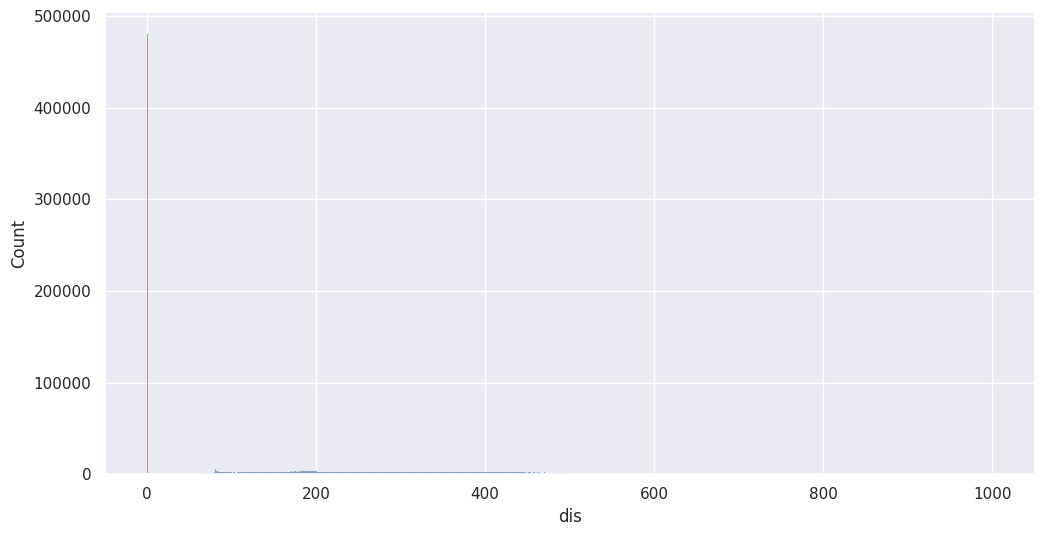

In [39]:
fig = plt.figure(figsize=(12, 6))

sns.histplot(df['dis'], bins = 1000)

### 2.2.3. Cột `time` và `phase`

Text(0.5, 1.0, 'phase')

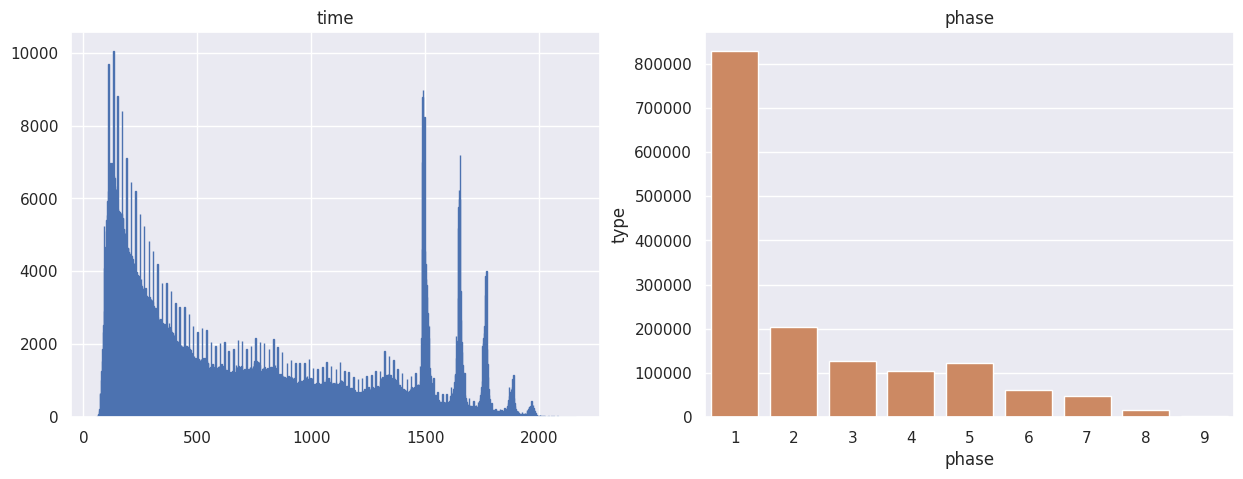

In [40]:
fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))

axes[0].hist(df['time'], bins = 1000, edgecolor = 'C0')

data = df.groupby(by = ['phase']).count().reset_index()[['phase', 'type']]
sns.barplot(data = data, x = 'phase', y = 'type', ax = axes[1], color = 'C1')

axes[0].set_title('time')
axes[1].set_title('phase')

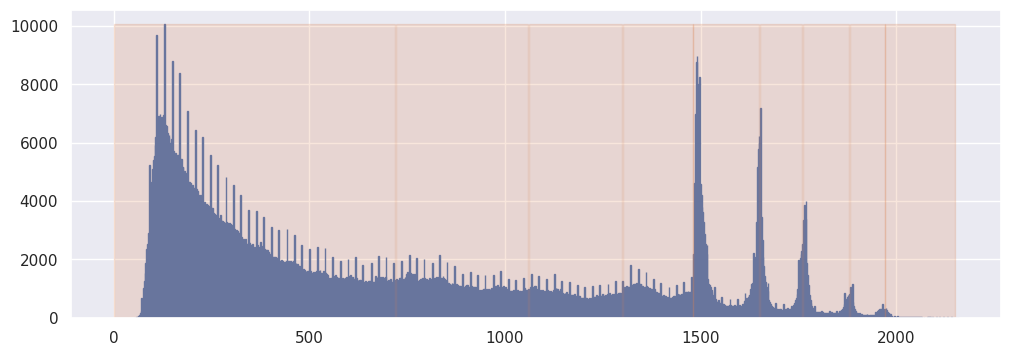

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))

y, _, _ = plt.hist(df['time'], bins = 1000, edgecolor = 'C0')

phase_rect = [(0, 720), (721, 1060), (1061, 1300), (1301, 1480), (1481, 1650), (1651, 1760), (1761, 1880), (1881, 1970), (1971, 2150)]

for rect in phase_rect:
    ax.add_patch(patches.Rectangle((rect[0], 0), rect[1] - rect[0], y.max(), color = 'C1', alpha = 0.2))

### 2.2.4. Cột `killed_by` và `type`

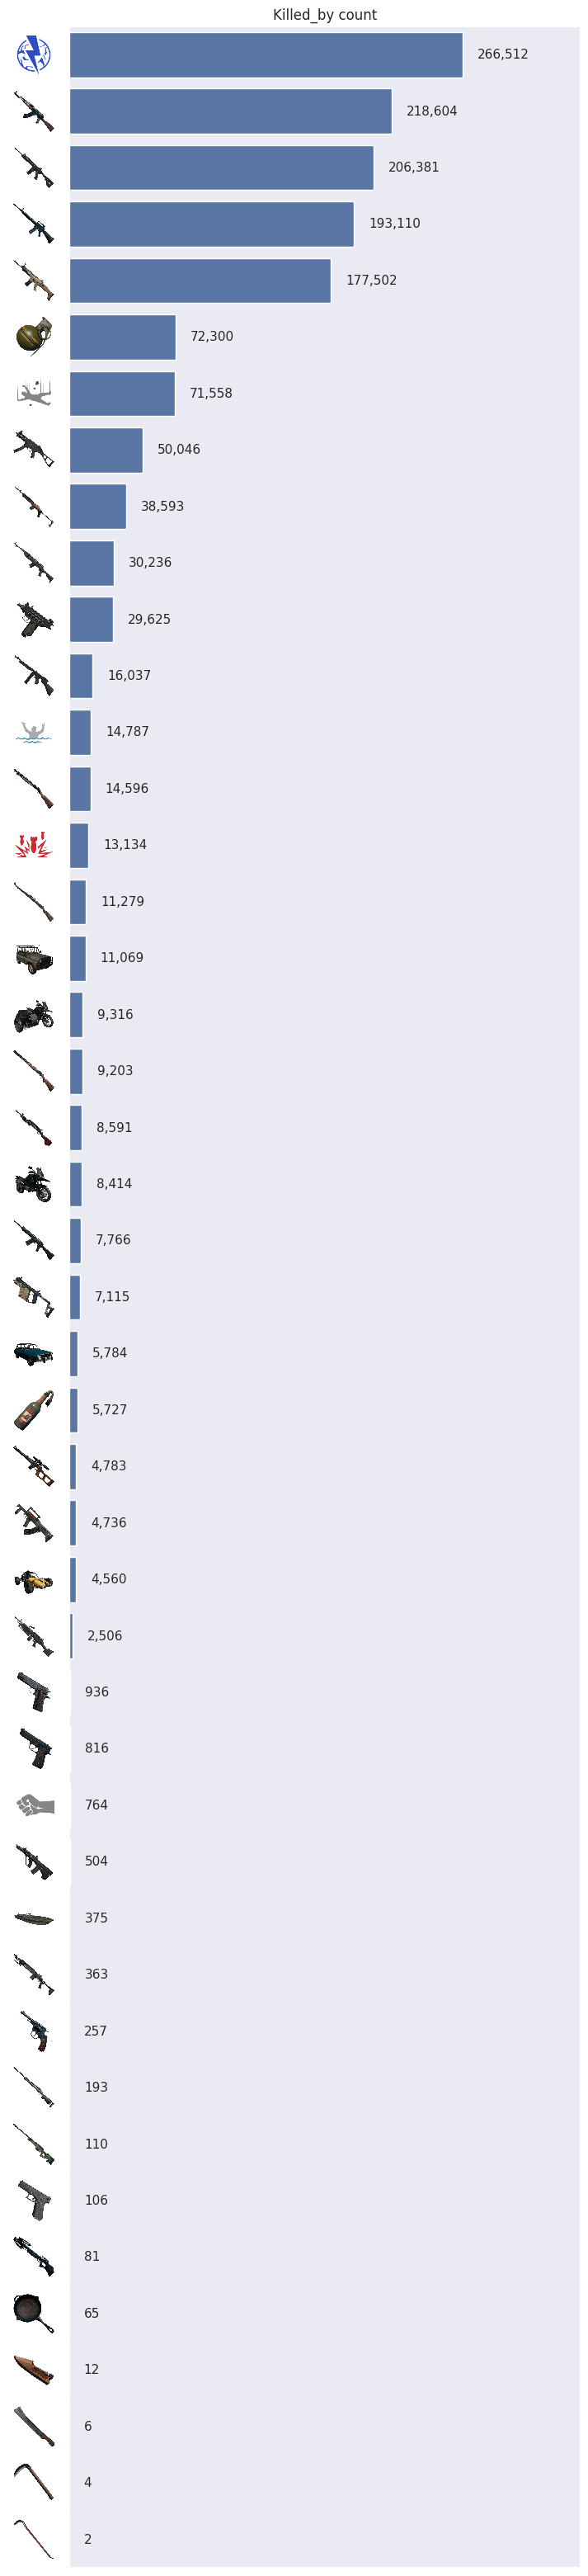

In [42]:
data = df['killed_by'].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(8, 40))
ax = sns.barplot(data = data, x = 'killed_by', y = 'index', color = 'C0')

ax.set_xlim(0, data['killed_by'].max() * 1.3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(visible = False)
ax.set_title('Killed_by count')

#annotate the bars
for i, v in enumerate(data['killed_by']):
    ax.text(v + 10000, i, f'{v:,}', va = 'center', fontsize = 11)

#use asset item as tick labels
for i, v in enumerate(data['index']):  
    img = plt.imread('asset/item/' + v +'.png', format = 'png')

    imagebox = OffsetImage(img, zoom = 0.07)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, (0, 0),
                        xybox=(-10000, i),
                        xycoords=("data"),
                        box_alignment = (1, 0.5),
                        bboxprops = {'edgecolor': 'none'})

    ax.add_artist(ab)


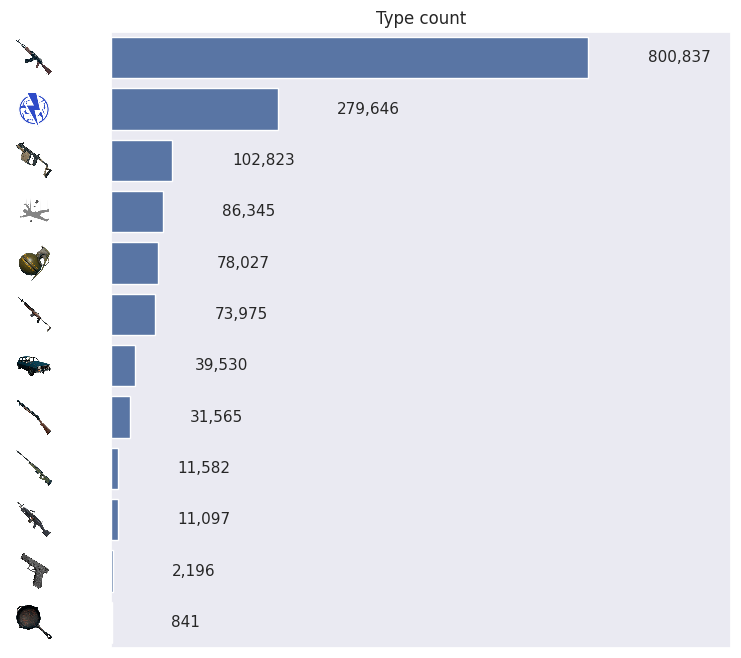

In [43]:
data = df['type'].value_counts().reset_index()

fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.barplot(data = data, x = 'type', y = 'index', color = 'C0')

ax.set_xlim(0, data['type'].max() * 1.3)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(visible = False)
ax.set_title('Type count')

#annotate the bars
for i, v in enumerate(data['type']):
    ax.text(v + 100000, i, f'{v:,}', va = 'center', fontsize = 11)

#use icon as tick labels
for i, v in enumerate(data['index']):  
    img = plt.imread('asset/type_item/' + v +'.png')

    imagebox = OffsetImage(img, zoom = 0.05)
    imagebox.image.axes = ax

    ab = AnnotationBbox(imagebox, (0, 0),
                        xybox=(-100000, i),
                        xycoords=("data"),
                        box_alignment = (1, 0.5),
                        bboxprops = {'edgecolor': 'none'})

    ax.add_artist(ab)

## 2.3. Phân bố dữ liệu giữa các cột với nhau
### 2.3.1. Đếm `killed_by` theo từng `type`

In [44]:
datas = [
    df[df['type'] == 'AR']['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'SMG') | (df['type'] == 'Shotgun')]['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'DMR') | (df['type'] == 'SR')]['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'Handgun')]['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'Melee')]['killed_by'].value_counts().reset_index(),
    df[(df['type'] == 'Throwable') | (df['type'] == 'Zone') | (df['type'] == 'Self') | (df['type'] == 'LMG')]['killed_by'].value_counts().reset_index()
]

titles = ['AR', 'SMG & Shotgun', 'DMR & SR', 'Handgun', 'Melee', 'Throwable & Zone & Self & LMG']

FileNotFoundError: [Errno 2] No such file or directory: 'visualization/killed_by_count_by_AR.png'

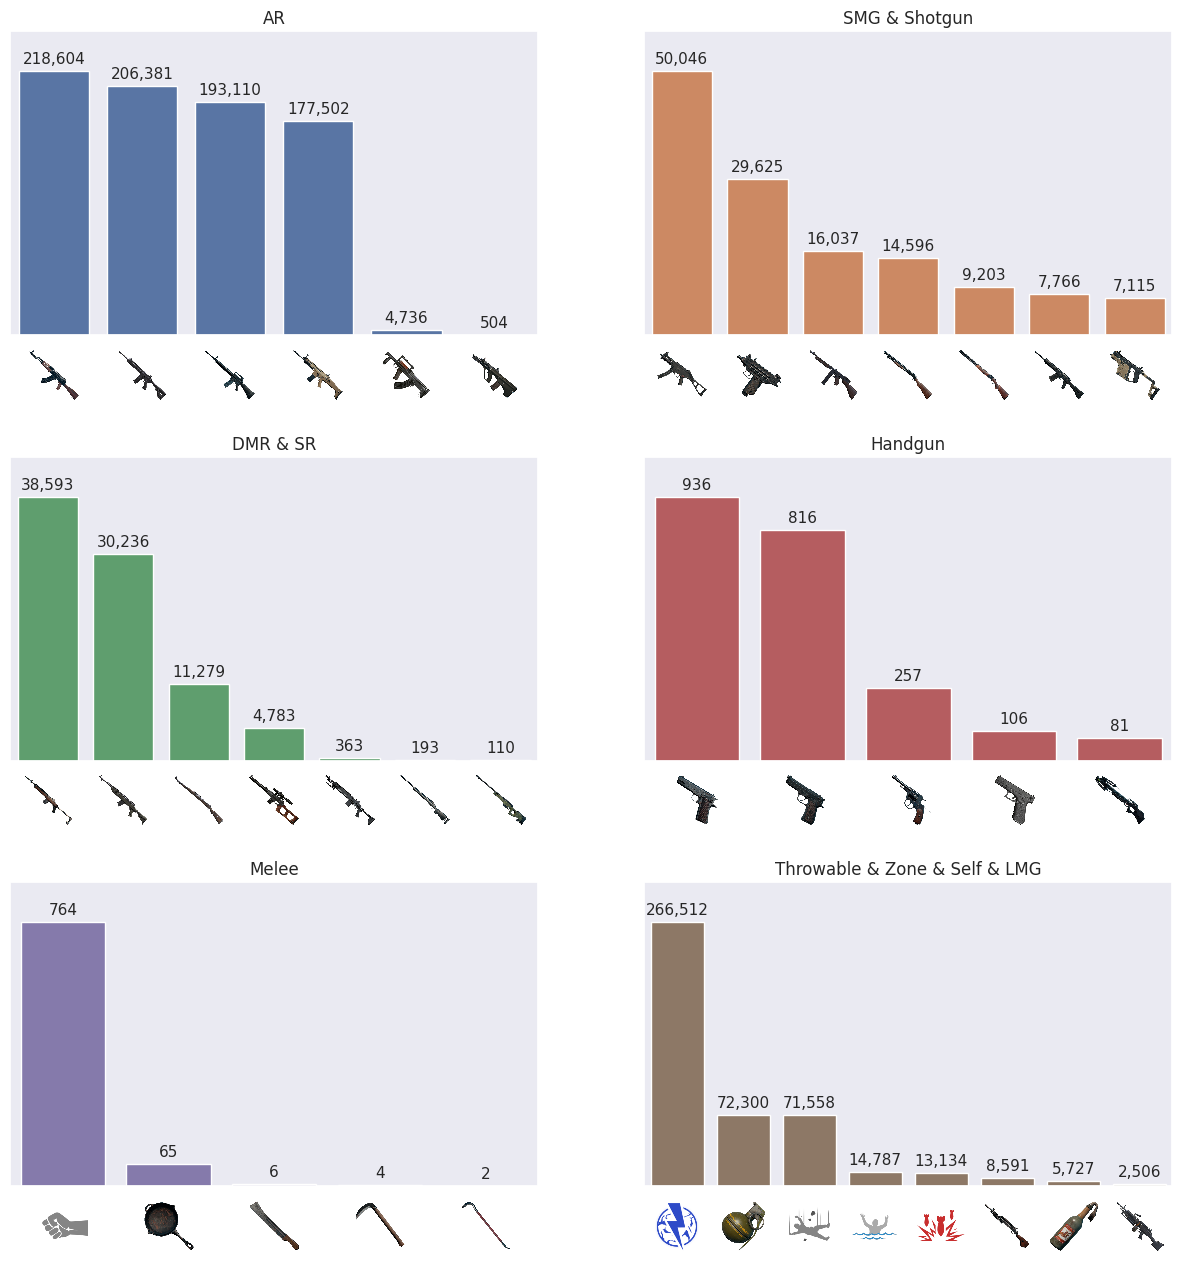

In [45]:
fig, axes = plt.subplots(ncols = 2, nrows = 3, figsize = (15, 15))
fig.subplots_adjust(hspace = 0.4)

for i, ax in enumerate(axes.flat):
    sns.barplot(data = datas[i], x = 'index', y = 'killed_by', ax = ax, color = f'C{i}')
    ax.set_title(titles[i])

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_yticklabels([])
    ax.grid(visible = False)
    
#annotate the bars
for ax in axes.flat:
    max_h = max([v.get_height() for v in ax.patches])
    ax.set_ylim(0, max_h * 1.15)
    for j, v in enumerate(ax.patches):
        ax.text(v.get_x() + v.get_width() / 2, v.get_height() + max_h * 0.03, f'{int(v.get_height()):,}', ha = 'center', fontsize = 11)

#use asset item as tick labels
for ax in axes.flat:
    max_h = max([v.get_height() for v in ax.patches])
    for i, v in enumerate(ax.get_xticklabels()):
        img = plt.imread('asset/item/' + v.get_text() +'.png', format = 'png')

        imagebox = OffsetImage(img, zoom = 0.07)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, (0, 0),
                            xybox=(i, -max_h * 0.15),
                            xycoords=("data"),
                            box_alignment = (0.5, 0.5),
                            bboxprops = {'edgecolor': 'none'})

        ax.add_artist(ab)
    ax.set_xticklabels([])

#save the figure
for ax in axes.flat:
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())